In [87]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Stage 2: Trevor
### Weekly stats for North Carolina

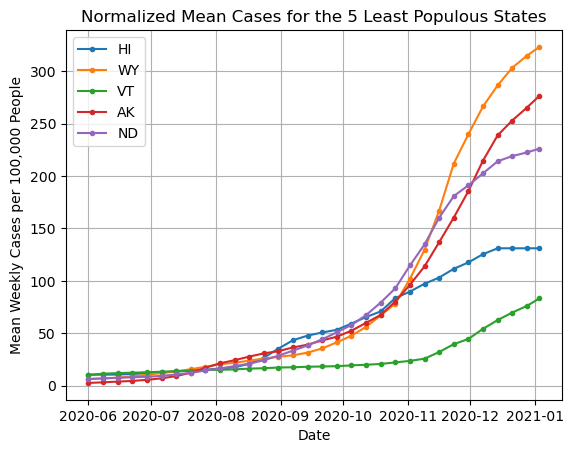

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Load COVID data from CSV file
covid_data = pd.read_csv('./data/super_covid_data.csv')

# Extract metadata columns
metadata_columns = covid_data.columns[:4].tolist() + [covid_data.columns[-1]]
metadata = covid_data[metadata_columns]
data_without_metadata = covid_data.drop(columns=metadata_columns)

# Filter for cases and deaths
case_columns = [col for col in data_without_metadata.columns if 'cases' in col.lower()]
death_columns = [col for col in data_without_metadata.columns if 'deaths' in col.lower()]

cases_data = data_without_metadata[case_columns]
deaths_data = data_without_metadata[death_columns]

# Clean column names for cases and deaths
cases_data.columns = [col.replace('_cases', '') for col in cases_data.columns]
deaths_data.columns = [col.replace('_deaths', '') for col in deaths_data.columns]

# Convert column names to datetime format
cases_data.columns = [pd.to_datetime(col, errors='coerce') for col in cases_data.columns]
deaths_data.columns = [pd.to_datetime(col, errors='coerce') for col in deaths_data.columns]

# Define date range
start_date = pd.to_datetime('2020-06-01')
end_date = pd.to_datetime('2021-01-03')

# Filter data for the specified date range
cases_data = cases_data.loc[:, cases_data.columns[(cases_data.columns >= start_date) & (cases_data.columns <= end_date)]]
deaths_data = deaths_data.loc[:, deaths_data.columns[(deaths_data.columns >= start_date) & (deaths_data.columns <= end_date)]]

# Aggregate weekly data
weekly_cases = cases_data.iloc[:, ::7].copy()
weekly_cases = pd.concat([weekly_cases, cases_data.iloc[:, -1:]], axis=1)

weekly_deaths = deaths_data.iloc[:, ::7].copy()
weekly_deaths = pd.concat([weekly_deaths, deaths_data.iloc[:, -1:]], axis=1)

# Combine weekly data with metadata
cases_weekly_with_metadata = pd.concat([metadata, weekly_cases], axis=1)
deaths_weekly_with_metadata = pd.concat([metadata, weekly_deaths], axis=1)

# Function to calculate statistics for a given state
def calculate_state_stats(state_abbreviation, weekly_data, normalization=1):
    if 'State' not in weekly_data.columns:
        print("Missing 'State' column in DataFrame.")
        return pd.DataFrame()
    
    state_data = weekly_data[weekly_data['State'] == state_abbreviation]
    
    if state_data.empty:
        print(f"No data available for state: {state_abbreviation}")
        return pd.DataFrame()
    
    total_population = state_data['population'].sum()
    
    if total_population == 0:
        print(f"Population is zero for state: {state_abbreviation}")
        return pd.DataFrame()
    
    state_data = state_data.drop(columns=['State', 'StateFIPS', 'population', 'County Name', 'countyFIPS'])
    normalized_values = state_data.div(total_population, axis=0) * normalization
    stats_summary = normalized_values.agg(['mean', 'median'])
    
    return stats_summary.T

# Identify the 5 least populous states
least_populous_states = covid_data.groupby('State')['population'].sum().nsmallest(5).index
normalization_factor = 100000

# Plotting the data
fig, ax = plt.subplots()
for state in least_populous_states:
    state_statistics = calculate_state_stats(state, cases_weekly_with_metadata, normalization_factor)
    if not state_statistics.empty:
        ax.plot(state_statistics.index, state_statistics['mean'], label=state, marker='.')

# Configure plot settings
ax.legend()
ax.set_title('Normalized Mean Cases for the 5 Least Populous States')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Weekly Cases per 100,000 People')
ax.grid()
plt.show()


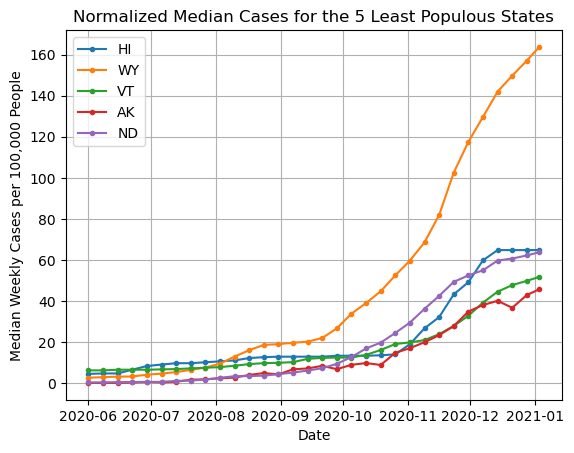

In [91]:
# Create a plot for normalized median cases of the least populous states
fig, ax = plt.subplots()
for state in least_populous_states: 
    state_statistics = calculate_state_stats(state, cases_weekly_with_metadata, normalization_factor)
    if not state_statistics.empty:
        ax.plot(state_statistics.index, state_statistics['median'], label=state, marker='.')

# Configure plot settings
ax.legend()
ax.set_title('Normalized Median Cases for the 5 Least Populous States')
ax.set_xlabel('Date')
ax.set_ylabel('Median Weekly Cases per 100,000 People')
ax.grid()
plt.show()


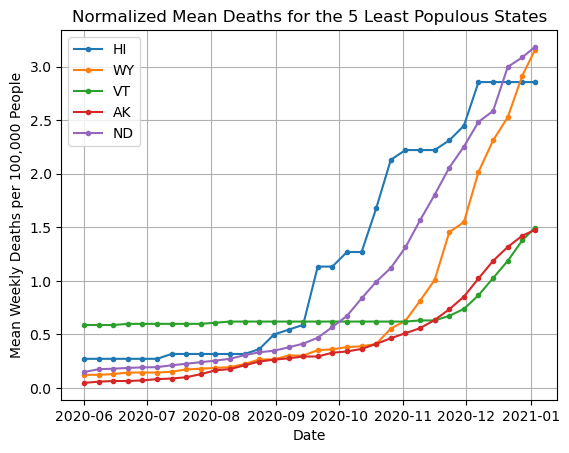

In [92]:
# Create a plot for normalized mean deaths of the least populous states
fig, ax = plt.subplots()
for state in least_populous_states: 
    state_statistics = calculate_state_stats(state, deaths_weekly_with_metadata, normalization_factor)
    if not state_statistics.empty:
        ax.plot(state_statistics.index, state_statistics['mean'], label=state, marker='.')

# Configure plot settings
ax.legend()
ax.set_title('Normalized Mean Deaths for the 5 Least Populous States')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Weekly Deaths per 100,000 People')
ax.grid()
plt.show()


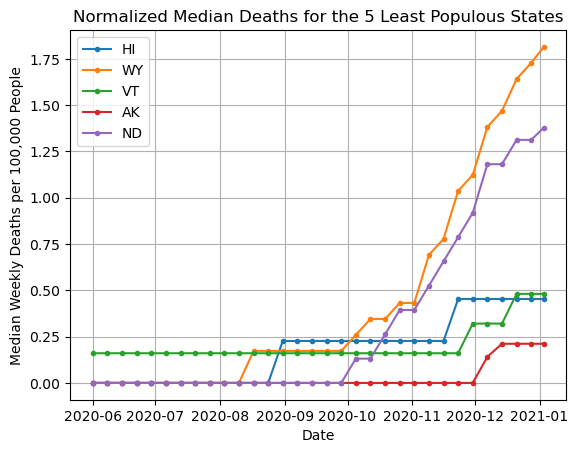

In [93]:
# Create a plot for normalized median deaths of the least populous states
fig, ax = plt.subplots()
for state in least_populous_states:  
    state_statistics = calculate_state_stats(state, deaths_weekly_with_metadata, normalization_factor)
    if not state_statistics.empty:
        ax.plot(state_statistics.index, state_statistics['median'], label=state, marker='.')

# Configure plot settings
ax.legend()
ax.set_title('Normalized Median Deaths for the 5 Least Populous States')
ax.set_xlabel('Date')
ax.set_ylabel('Median Weekly Deaths per 100,000 People')
ax.grid()
plt.show()


# State data:

There are some interesting trends in the data. For example, Hawaii was on the lower end of both mean and median cases, but the mean deaths shot above the other states incredibly quickly during October of 2020. The median deaths for Hawaii did not follow the same trend, which leads me to assume some counties within Hawaii skew the data with higher death counts. All states jump near the end of the data in December, which I assume is a result of increased travel and gathering sizes around the holidays. I'm not too sure about the normalized mean deaths, perhaps there was a delay in data submission that lead to so much time with no change visible. 

The median cases of Wyoming were much higher than the rest of the states AND the mean cases of Wyoming, which I assume is a result of cases being more spread out.

In [95]:
# Filter data for North Carolina (NC)
nc_cases_data = cases_weekly_with_metadata[cases_weekly_with_metadata['State'] == 'NC']
nc_death_data = deaths_weekly_with_metadata[deaths_weekly_with_metadata['State'] == 'NC']

# Save county populations for later
nc_county_pops = nc_death_data.loc[:, ['County Name', 'population']]
nc_county_pops.set_index('County Name', inplace=True)

# Prepare death data
nc_death_data = nc_death_data.drop(columns=['State', 'StateFIPS', 'population', 'countyFIPS'])
nc_death_data.set_index(['County Name'], inplace=True)
nc_death_data['mean'] = nc_death_data.mean(axis=1)
top_5_counties = nc_death_data.sort_values(by='mean', ascending=False).head().index

# Prepare case data
nc_cases_data = nc_cases_data.drop(columns=['State', 'StateFIPS', 'population', 'countyFIPS'])
nc_cases_data.set_index(['County Name'], inplace=True)

# Transpose the dataframes for further analysis
nc_cases_data = nc_cases_data.T
nc_death_data = nc_death_data.drop(columns='mean').T


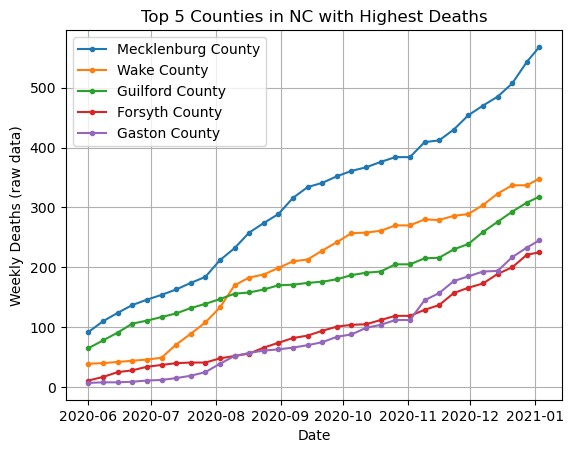

In [96]:
fig, ax = plt.subplots()
for county in top_5_counties:
    ax.plot(nc_death_data.index, nc_death_data[county], label=county, marker='.')

ax.legend()
ax.title.set_text('Top 5 Counties in NC with Highest Deaths')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Deaths (raw data)')
ax.grid()
plt.show()

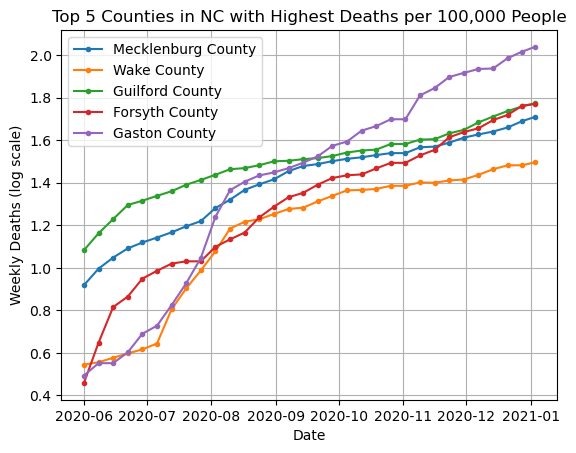

In [97]:
fig, ax = plt.subplots()
for county in top_5_counties:
    county_pop = nc_county_pops.loc[county].iloc[0]  # Use NC county populations
    normalized = np.log10(nc_death_data[county].div(county_pop) * 100_000)  # Normalize using NC death data
    ax.plot(nc_death_data.index, normalized, label=county, marker='.')  # Plot with NC data

ax.legend()
ax.title.set_text('Top 5 Counties in NC with Highest Deaths per 100,000 People')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Deaths (log scale)')
ax.grid()
plt.show()


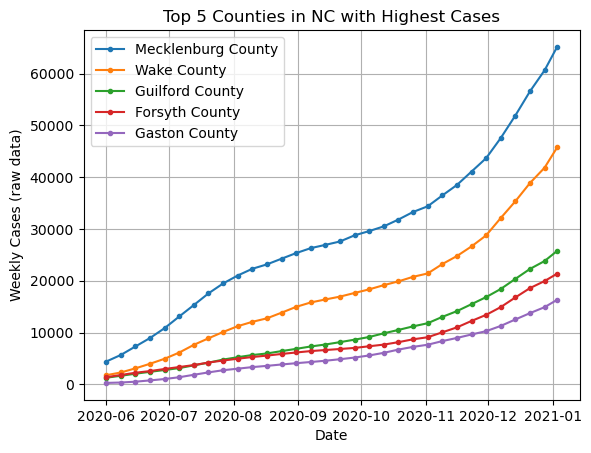

In [98]:
fig, ax = plt.subplots()
for county in top_5_counties:
    ax.plot(nc_cases_data.index, nc_cases_data[county], label=county, marker='.')  # Use NC case data

ax.legend()
ax.title.set_text('Top 5 Counties in NC with Highest Cases')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Cases (raw data)')
ax.grid()
plt.show()


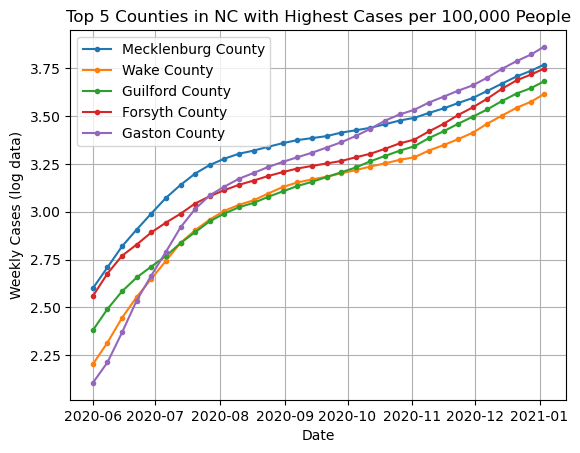

In [100]:
fig, ax = plt.subplots()
for county in top_5_counties:
    county_pop = nc_county_pops.loc[county].iloc[0]  # Use NC county populations
    normalized = np.log10(nc_cases_data[county].div(county_pop) * 100_000)  # Normalize using NC case data
    ax.plot(nc_cases_data.index, normalized, label=county, marker='.')

ax.legend()
ax.title.set_text('Top 5 Counties in NC with Highest Cases per 100,000 People')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Cases (log data)')
ax.grid()
plt.show()


# County data:

The normalized data for each county follow similar trends, but Wake County seems to have lasted a little longer before spiking in deaths to match the rest of the counties. This could have been a result of overcrowding and medical professionals being short on equipment, but that's just a guess. The normalized graphs follow a fairly logarithmic growth across the board on cases and deaths. Aside from the aformentioned slight deviations, the NC county graphs seem to follow a similar trend to the US as a whole.